# Detección de Poses con MediaPipe
## Introducción a MediaPipe Pose   

MediaPipe Pose es una solución de detección de poses corporales que permite identificar y rastrear hasta 33 puntos clave (landmarks) del cuerpo humano en tiempo real, tanto en imágenes estáticas como en video. Desarrollada por Google, esta librería facilita la implementación de aplicaciones que requieren análisis de movimiento y posturas humanas.   

### ¿Qué es un sistema de detección de poses?   

Un sistema de detección de poses permite identificar automáticamente la posición y orientación de las partes del cuerpo de una persona a partir de imágenes o videos. El sistema localiza puntos clave como articulaciones y extremidades, creando un "esqueleto" digital que representa la pose de la persona.

Instalación de MediaPipe
Para comenzar a utilizar MediaPipe Pose, necesitamos instalar las bibliotecas necesarias:   

````
# Instalación de las librerías necesarias
pip install mediapipe opencv-python numpy
````

## Conceptos básicos
### Landmarks o puntos clave   

MediaPipe Pose detecta 33 puntos clave en el cuerpo humano:

- 0-10: Cara
- 11-22: Parte superior del cuerpo (hombros, codos, muñecas)
- 23-32: Parte inferior del cuerpo (caderas, rodillas, tobillos)

Cada landmark contiene:

- Coordenadas x, y en la imagen (normalizadas entre 0.0 y 1.0)
- Coordenada z que representa la "profundidad" relativa
- Valor de visibilidad (entre 0.0 y 1.0) que indica cuán visible es el punto

### Conexiones
Las conexiones representan las líneas que unen los diferentes landmarks, permitiendo visualizar el esqueleto completo.   

Primer ejemplo: Detección básica de pose
Este ejemplo muestra cómo detectar la pose en una imagen y visualizar los resultados:

2025-04-07 11:13:02.494391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744024382.627822     468 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744024382.664494     468 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-07 11:13:02.967116: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dimensiones de la imagen: 4912x7360


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1744024390.840868     849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744024390.915215     849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744024390.933173     858 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Pose detectada con éxito


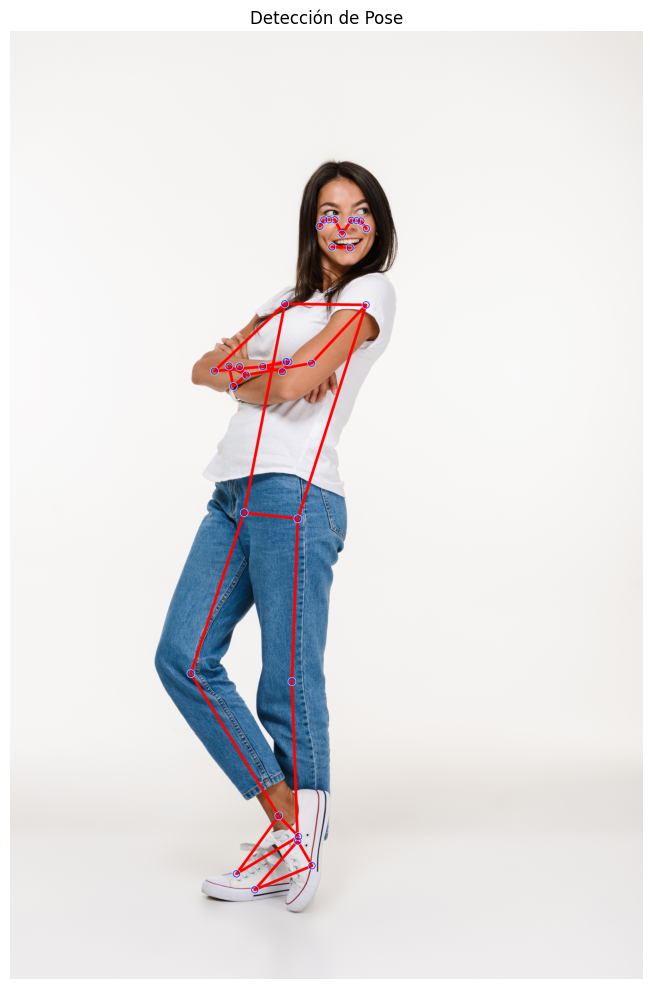

Imagen guardada como 'pose_detectada.jpg'


In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Inicializar los módulos de MediaPipe
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# Preparar la imagen - asegúrate de que la ruta sea correcta
imagen = cv2.imread('./img/persona.jpg')


altura, anchura, _ = imagen.shape
print(f"Dimensiones de la imagen: {anchura}x{altura}")

# Inicializar el detector de poses con configuración más ligera
with mp_pose.Pose(
  static_image_mode=True,
  model_complexity=0,  # Usar el modelo más ligero
  enable_segmentation=False,
  min_detection_confidence=0.5
) as pose:
  # Convertir imagen de BGR a RGB
  imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

  # Procesar la imagen
  resultados = pose.process(imagen_rgb)

  # Crear una copia para dibujar
  imagen_resultado = imagen_rgb.copy()

  # Verificar si se detectaron poses
  if resultados.pose_landmarks:
      print("Pose detectada con éxito")
      # Dibujar los landmarks y conexiones
      mp_drawing.draw_landmarks(
          imagen_resultado,
          resultados.pose_landmarks,
          mp_pose.POSE_CONNECTIONS,
          landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0,0,255), thickness=3, circle_radius=25),
          connection_drawing_spec=mp_drawing.DrawingSpec(color=(255,0,0), thickness=20)
)
  else:
      print("No se detectó ninguna pose")

  # Mostrar con matplotlib en lugar de cv2.imshow
  plt.figure(figsize=(10, 10))
  plt.imshow(imagen_resultado)
  plt.title('Detección de Pose')
  plt.axis('off')
  plt.tight_layout()
  plt.show()

  # Guardar la imagen
  cv2.imwrite('pose_detectada.jpg', cv2.cvtColor(imagen_resultado, cv2.COLOR_RGB2BGR))
  print("Imagen guardada como 'pose_detectada.jpg'")

**Ejemplo con vídeo en tiempo real**   

A continuación, se muestra cómo implementar la detección de pose en tiempo real usando la webcam:

***Para usar en un dev container es necesario modificar el fichero 'devcontainer.json':***

````
"runArgs": [
    "--device=/dev/video0:/dev/video0"
]
````


In [2]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Inicializar los módulos de MediaPipe
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# Abrir la webcam
cap = cv2.VideoCapture(0)

# Inicializar el detector de poses (para vídeo)
with mp_pose.Pose(
    static_image_mode=False,
    model_complexity=1,
    smooth_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as pose:

    plt.ion()  # Modo interactivo de matplotlib
    fig, ax = plt.subplots(figsize=(10, 8))

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            print("Error al leer el frame.")
            break

        # Procesamiento de imagen
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resultados = pose.process(frame_rgb)

        # Dibujar landmarks si se detectaron
        if resultados.pose_landmarks:
            mp_drawing.draw_landmarks(
                frame_rgb,
                resultados.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

        # Mostrar imagen usando matplotlib
        clear_output(wait=True)
        ax.clear()
        ax.imshow(frame_rgb)
        ax.axis('off')
        plt.title('Detección de pose con MediaPipe')
        plt.pause(0.001)

    # Liberar recursos
    cap.release()
    plt.ioff()
    plt.close()

[ WARN:0@67.539] global cap_v4l.cpp:913 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@67.540] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
W0000 00:00:1744024447.957461    1019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744024447.983891    1019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


***Para usar en un `venv`en el host directamente, aplicar el siguiente código:***

In [ ]:
import cv2
import mediapipe as mp
import time

# Inicializar los módulos de MediaPipe
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# Abrir la webcam
cap = cv2.VideoCapture(0)

# Inicializar el detector de poses (para vídeo)
with mp_pose.Pose(
    static_image_mode=False,         # Modo de video (no imagen estática)
    model_complexity=1,              # Complejidad media
    smooth_landmarks=True,           # Suavizado de landmarks
    min_detection_confidence=0.5,    # Confianza mínima para detección
    min_tracking_confidence=0.5      # Confianza mínima para seguimiento
) as pose:
    
    while cap.isOpened():
        # Leer frame de la webcam
        success, frame = cap.read()
        if not success:
            print("Error al leer el frame.")
            continue
        
        # Para mejorar el rendimiento, marcar la imagen como no escribible
        frame.flags.writeable = False
        
        # Convertir a RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Procesar el frame
        resultados = pose.process(frame_rgb)
        
        # Volver a hacer la imagen escribible para dibujar
        frame.flags.writeable = True
        
        # Dibujar landmarks si se detectaron
        if resultados.pose_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                resultados.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
            
            # Opcional: mostrar FPS
            cv2.putText(frame, f"FPS: {int(cap.get(cv2.CAP_PROP_FPS))}", 
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Mostrar el frame procesado
        cv2.imshow('MediaPipe Pose', frame)
        
        # Salir si se presiona 'ESC'
        if cv2.waitKey(5) & 0xFF == 27:
            break
    
    # Liberar recursos
    cap.release()
    cv2.destroyAllWindows()

**Ejemplo práctico: Análisis de postura**   

Este ejemplo muestra cómo extraer información significativa de los landmarks para analizar la postura de una persona:

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import math

# Inicializar MediaPipe
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Función para calcular el ángulo entre tres puntos
def calcular_angulo(a, b, c):
    """
    Calcula el ángulo entre tres puntos en grados.
    Los puntos deben ser arrays con coordenadas [x, y]
    """
    # Vectores
    ba = np.array([a[0] - b[0], a[1] - b[1]])
    bc = np.array([c[0] - b[0], c[1] - b[1]])
    
    # Producto escalar
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    
    # Convertir a grados
    return np.degrees(angle)

# Iniciar webcam
cap = cv2.VideoCapture(0)

# Configurar el detector de poses
with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose:
    
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            continue
            
        # Convertir BGR a RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_rgb.flags.writeable = False
        
        # Procesar imagen
        results = pose.process(image_rgb)
        
        image.flags.writeable = True
        image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
        
        # Extraer landmarks
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            
            # Obtener coordenadas para el codo derecho
            hombro = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, 
                     landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
            codo = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x, 
                   landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
            muñeca = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x, 
                     landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
            
            # Calcular el ángulo del codo
            angulo_codo = calcular_angulo(hombro, codo, muñeca)
            
            # Mostrar el ángulo en la imagen
            h, w, _ = image.shape
            cx, cy = int(codo[0] * w), int(codo[1] * h)
            cv2.putText(image, f"Angulo: {int(angulo_codo)}", 
                       (cx - 50, cy - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
            
            # Dibujar landmarks
            mp_drawing.draw_landmarks(
                image,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS)
        
        # Mostrar imagen
        cv2.imshow('MediaPipe Pose Analysis', image)
        
        if cv2.waitKey(5) & 0xFF == 27:
            break
            
    cap.release()
    cv2.destroyAllWindows()

## Aplicaciones prácticas de la detección de poses
La detección de poses tiene múltiples aplicaciones en diferentes campos:

- Deporte y fitness:

    - Análisis de técnica deportiva
    - Conteo de repeticiones en ejercicios
    - Corrección de posturas


- Salud:

    - Rehabilitación física
    - Evaluación de movilidad
    - Detección de caídas en ancianos


- Interacción Persona-Computadora:

    - Control de interfaces mediante gestos
    - Videojuegos interactivos
    - Realidad virtual y aumentada


- Seguridad:

    - Detección de comportamientos sospechosos
    - Análisis de multitudes



**Limitaciones y consideraciones**

- **Oclusiones**: La precisión disminuye cuando partes del cuerpo están ocultas.
- **Rendimiento**: En dispositivos con recursos limitados puede haber retraso.
- **Iluminación**: Condiciones de iluminación pobres afectan la detección.
- **Privacidad**: Considerar implicaciones éticas al recopilar datos de poses humanas.

## Conclusión   

MediaPipe Pose es una herramienta potente y accesible para la detección de poses humanas. Su implementación en Python es relativamente sencilla y permite desarrollar aplicaciones que requieren análisis del movimiento humano. Con solo unas pocas líneas de código, es posible crear sistemas capaces de interpretar la postura corporal en diferentes contextos.   